# Setup

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random
import gc

SkLearn libraries:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

TensorFlow libraries:

In [ ]:
import tensorflow as tf
from tensorflow import keras as tfk
!pip install -q keras_cv
import keras_cv as kcv
from keras_cv.layers import RandomApply
print(f"TensorFlow version {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 24.4 MB/s eta 0:00:00
TensorFlow version 2.17.1


Some settings:

In [ ]:
SEED = 42

# set seed for random
random.seed(SEED)

np.random.seed(SEED) # NumPy seed
tf.random.set_seed(SEED) # TensorFlow seed

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

tf.autograph.set_verbosity(0)
tf.compat.v1.set_random_seed(SEED)

Some viz settings:

In [ ]:
plt.tight_layout(); # cuter layout
pd.set_option('display.max_rows', None); # to show all layers of models

<Figure size 640x480 with 0 Axes>

# Data Handling

## Resource Downloads

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Import

In [ ]:
SHARED_DIR = "/content/gdrive/MyDrive/AN2DL_hw_1" # team-shared repo
MY_DIR = "/content/gdrive/MyDrive/blood_dir" # my working repo

Import the public set:

In [8]:
with np.load(SHARED_DIR+"/training_set.npz", allow_pickle=True) as data:
    images = data['images']
    labels = data['labels'].reshape(-1)
num_classes = len(np.unique(labels))
images.shape, labels.shape, num_classes

((13759, 96, 96, 3), (13759,), 8)

## Data Exploration

In [ ]:
def show_images(images, labels, n_images=5, n_cols=5, predict=False):
  """
  Visualises a set of randomyl sampled images of given size in a grid of given columns number, 
  along with true or predicted labels.
  """
  sns.set_style("whitegrid")  # Set Seaborn style

  n_rows = int(np.ceil(n_images / n_cols))

  # Define a base size for each subplot
  base_size = 5
  fig_size = (n_cols * base_size, n_rows * base_size)

  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
  axs = axs.flatten()

  random_idxs = np.random.choice(len(images), n_images, replace=False) # for random images
  # random_idxs = range(len(images)) # for ordered images

  images_to_show = images[random_idxs]
  labels_to_show = labels[random_idxs]

  if predict == True:
    preds_to_show = MODEL.predict(images_to_show)

  for i, ax in enumerate(axs[:n_images]):
    idx = range(len(labels))[random_idxs[i]]

    img_to_show = images_to_show[i]
    label = labels_to_show[i]

    img_title = f"Image {idx + 1} - Class {label}"

    if predict == True:
      pred = preds_to_show[i]
      suff = f" - Pred {pred}"
      img_title += suff

    ax.set_title(img_title, fontsize=21)
    ax.imshow(img_to_show)
    ax.axis('off')  # Hide axes ticks

  # Hide any remaining empty subplots
  for ax in axs[n_images:]:
    ax.axis('off')

  plt.tight_layout()
  plt.show()

Plot some images:

In [10]:
# show_images(images, labels, n_images=50)

Visualise class distributions:

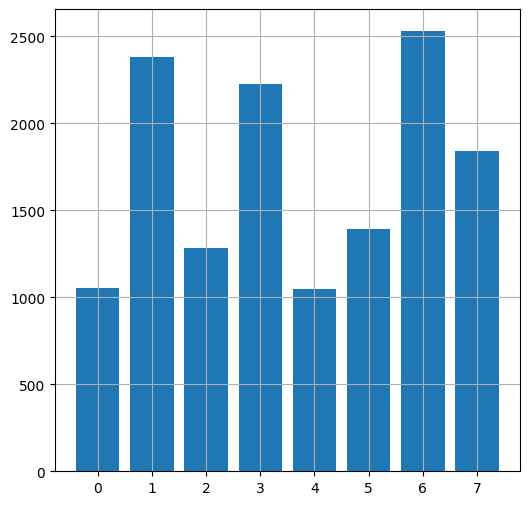

In [11]:
class_counts = np.bincount(labels)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.set_xticks(np.arange(num_classes), np.arange(num_classes))
ax.bar(np.arange(num_classes), class_counts)
ax.grid()

## Data Cleaning

Remove duplicates:

In [12]:
images, unique_idxs = np.unique(images, axis=0, return_index=True)
labels = labels[unique_idxs]
images.shape, labels.shape

((11953, 96, 96, 3), (11953,))

Remove anomalies:

In [ ]:
shrek = images[58] # isolated shrek image
rick = images[1008] # isolated rick image
# plt.imshow(shrek)
# plt.imshow(rick)

In [ ]:
shrek_idxs = np.all(images == shrek, axis=(1, 2, 3))
rick_idxs = np.all(images == rick, axis=(1, 2, 3))
print(f"{shrek_idxs.sum()} shreks")
print(f"{rick_idxs.sum()} rick")

1 shreks
1 rick


In [ ]:
idxs_to_delete = shrek_idxs + rick_idxs # outliers idxs to drop
images = np.delete(images, idxs_to_delete, axis=0) # cleaned images
labels = np.delete(labels, idxs_to_delete, axis=0) # cleaned labels
images.shape, labels.shape

((11951, 96, 96, 3), (11951,))

## Data Splitting

Split between train+val and test sets:

In [ ]:
val_split = 0.15 # train-val split

X_train, X_val, y_train, y_val = train_test_split(
    images, labels,
    test_size = val_split,
    random_state = SEED,
    shuffle = True,
    stratify = labels
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

del images, labels
gc.collect();

(10158, 96, 96, 3) (10158,)
(1793, 96, 96, 3) (1793,)


## Class Weighting

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
) # balanced custom class weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

## Tensors

In [ ]:
X_train = tf.convert_to_tensor(X_train/255.0, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.uint8)
X_val   = tf.convert_to_tensor(X_val/255.0, dtype=tf.float32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.uint8)
gc.collect();
X_train.device, X_train.dtype

('/job:localhost/replica:0/task:0/device:GPU:0', tf.float32)

# Model Init

## Model Loading

In [ ]:
def load_model(file_path, compile=True):
    """
    Wrapper method to load .keras model, compiled or not.
    """
    MODEL = tfk.models.load_model(file_path, compile=compile)
    return MODEL

In [ ]:
# file_path = f"params.keras"               # for model saved on local runtime
file_path = f"{MY_DIR}/params_cnxl_0.97.keras"    # for model saved on google drive
MODEL = load_model(file_path, compile=False)

## Model Definition

### FEN Import

In [ ]:
class FENModel():
    """
    Abstract class to import FENs.
    """
    @classmethod
    def __call__(self):
        raise NotImplementedError
    
    def get(self):
        """
        Abstract method to download and import FENs.
        """
        raise NotImplementedError

class FENConvNeXtBase(FENModel):
    @classmethod
    def get(self):
        FEN = tfk.applications.ConvNeXtBase(
            input_shape=(96, 96, 3),
            include_preprocessing=False,
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )
        return FEN

class FENConvNeXtXLarge(FENModel):
    @classmethod
    def get(self):
        FEN = tfk.applications.ConvNeXtXLarge(
            input_shape=(96, 96, 3),
            include_preprocessing=False,
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )
        return FEN

class FENEfficientNetV2M(FENModel):
    @classmethod
    def get(self):
        FEN = tfk.applications.EfficientNetV2M(
            input_shape=(96, 96, 3),
            include_preprocessing=False,
            include_top=False,
            weights="imagenet",
            pooling="avg",
        )
        return FEN

In [ ]:
FEN = FENConvNeXtXLarge.get()

### Model Creation

In [ ]:
def create_model(FEN):
    """
    Wrapper method to create model's computational graph
    """
    # initialise weights and regulariser
    gl_weights_init = tfk.initializers.GlorotNormal(seed=SEED) # Glorot-Xavier weights init for softmax layers
    he_weights_init = tfk.initializers.HeNormal(seed=SEED) # Kaiming-He weights init for ReLU layers

    # regularisers
    # reg = keras.regularizers.l2(1e-2) # L2 regularizer
    reg = None # no regularizer

    # computational graph
    inputs  = FEN.input # FEN input layer
    x       = FEN.output # FEN output layer
    x       = tfk.layers.Dense(1024, name="classifier", activation="swish", kernel_initializer=he_weights_init, kernel_regularizer=reg)(x)
    outputs = tfk.layers.Dense(8, name="predictor", activation="softmax", kernel_initializer=gl_weights_init, kernel_regularizer=reg)(x)

    MODEL = tfk.Model(inputs=inputs, outputs=outputs)
    return MODEL

In [ ]:
MODEL = create_model(FEN)

## Model Viz

In [ ]:
def _get_all_layers(layer, data):
    """
    Method to recursively unwind nested layers.
    """
    if isinstance(layer, tfk.Model):  # Check if the layer is a model (nested layers)
        for sub_layer in layer.layers:
            _get_all_layers(sub_layer, data)  # Recursively call for nested layers
    else:
        data.append({"Layer Name": layer.name, "Trainable": layer.trainable})

def get_model_df(model, nested=False):
    """
    Method to display in a tidy Pandas DataFrame all layers of a model (optionally unwinding nested ones) along with trainable parameters.
    """
    data = []
    for layer in model.layers:
        if nested:
            _get_all_layers(layer, data)  # Get all layers, including nested ones
        else:
            data.append({"Layer Name": layer.name, "Trainable": layer.trainable})
    return pd.DataFrame(data)

In [ ]:
# get_model_df(MODEL)

# Model Fitting

## Image Augmentation

In [ ]:
random_layers = [
    RandomApply(kcv.layers.RandAugment((0, 1)), rate=0.9),
    RandomApply(kcv.layers.JitteredResize((96, 96), (0.9, 1)), rate=0.7),
    RandomApply(kcv.layers.RandomTranslation(0.4, 0.4), rate=0.6),
    RandomApply(kcv.layers.RandomRotation(1), rate=0.6),
    RandomApply(kcv.layers.RandomSaturation(0.7), rate=0.3),
    RandomApply(kcv.layers.RandomContrast((0, 1), 0.7), rate=0.3),
]

augmenter = tfk.Sequential(random_layers)

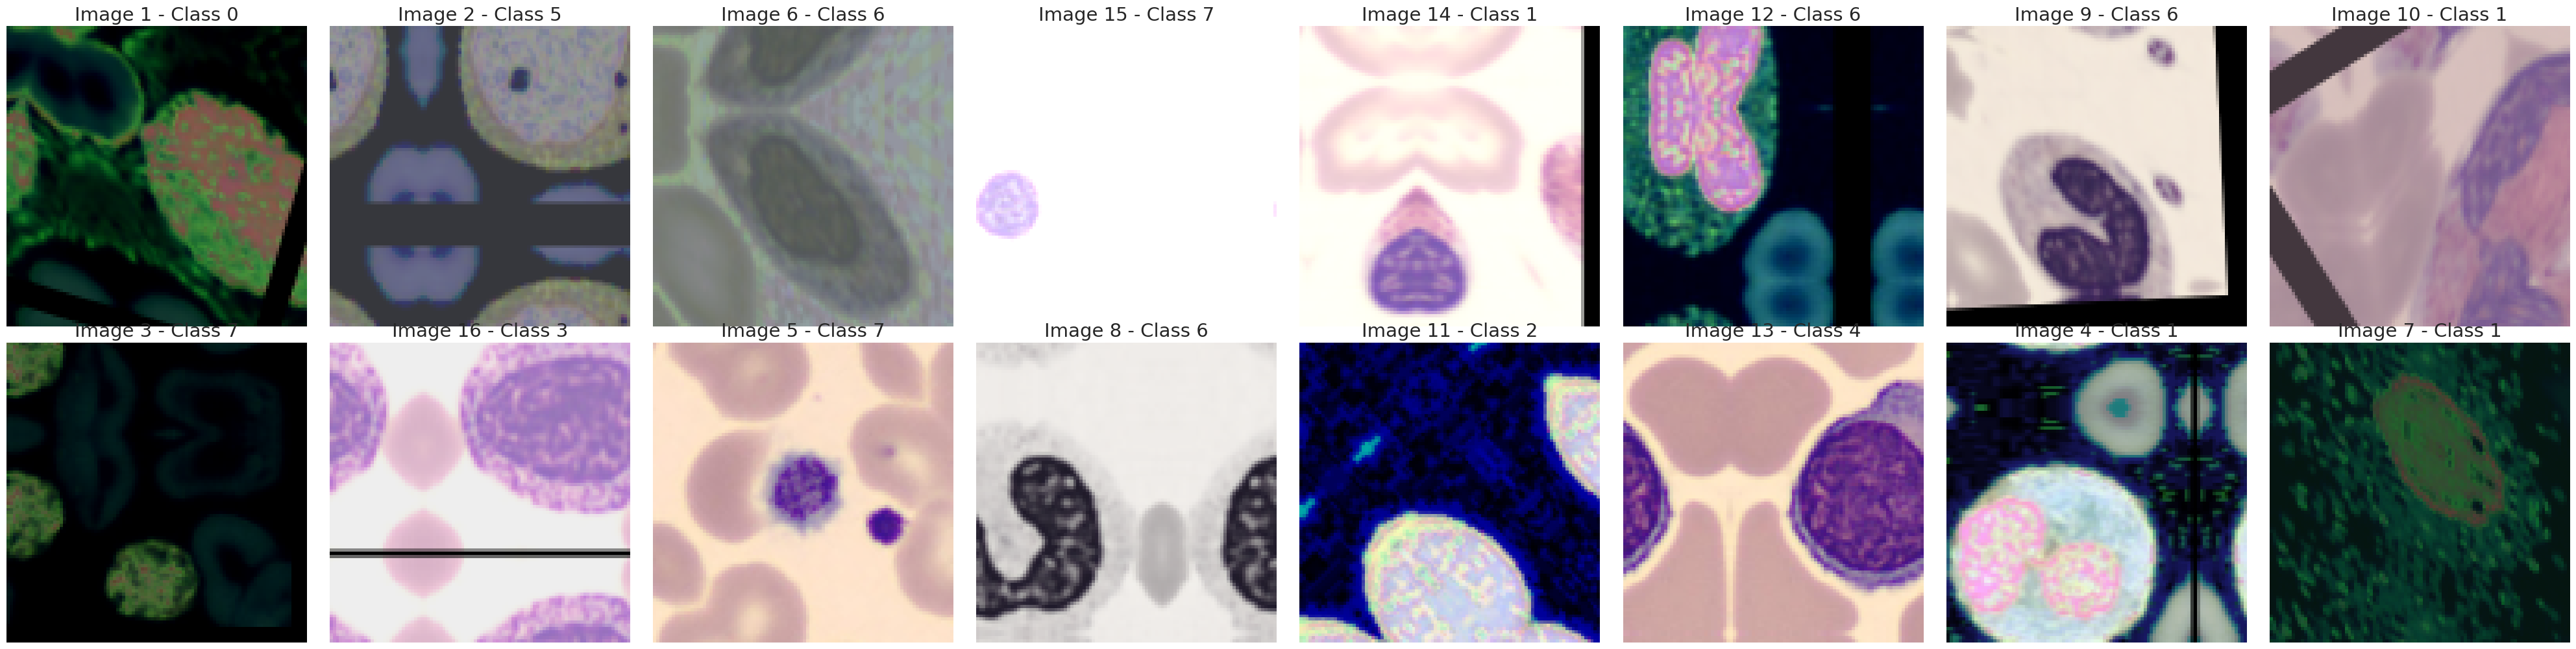

In [23]:
n_images = 16
aug_samples = augmenter(X_train[:n_images], training=True);
show_images(aug_samples[:n_images].numpy().astype(np.float32), y_train[:n_images].numpy(), n_images=n_images, n_cols=8)

## Transfer Learning

In [ ]:
def transfer_learning(model):
    """
    Wrapper method to setup TL
    """
    for i, layer in enumerate(model.layers):
        layer.trainable = False
    for layer in model.layers[-2:]:
        layer.trainable = True

In [ ]:
transfer_learning(MODEL)

## Fine Tuning

In [ ]:
def fine_tuning(model):
    """
    Wrapper method to setup FT
    """
    for layer in model.layers:
        layer.trainable=False
    for layer in model.layers[:]:
        layer.trainable=True

In [25]:
fine_tuning(MODEL)

## Model Compilation

In [26]:
get_model_df(MODEL, nested=False)

,Layer Name,Trainable
0,input_layer_15,True
1,convnext_xlarge_stem,True
2,convnext_xlarge_stage_0_block_0_depthwise_conv,True
3,convnext_xlarge_stage_0_block_0_layernorm,True
4,convnext_xlarge_stage_0_block_0_pointwise_conv_1,True
5,convnext_xlarge_stage_0_block_0_gelu,True
6,convnext_xlarge_stage_0_block_0_pointwise_conv_2,True
7,convnext_xlarge_stage_0_block_0_layer_scale,True
8,convnext_xlarge_stage_0_block_0_identity,True
9,convnext_xlarge_stage_0_block_1_depthwise_conv,True


Compile the model:

In [ ]:
def compile_model(MODEL, lr=1e-4):
    """
    Wrapper method to compile model.
    """
    loss = tfk.losses.SparseCategoricalCrossentropy()
    optimizer = tfk.optimizers.Lion(
        learning_rate=lr,
        weight_decay=1e-4,
        gradient_accumulation_steps=2,
    )

    metrics = ['accuracy']
    MODEL.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [28]:
compile_model(MODEL, lr=1e-5)

## Training

Build the augmented train dataset:

In [ ]:
BATCH_SIZE=64 # batch size for dataset handling and training
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # train dataset
train_ds = train_ds.map(
    lambda x, y: (augmenter(x), y),
    num_parallel_calls=tf.data.AUTOTUNE) # online augmentation mapping

Compute initial losses:


In [30]:
# MODEL.evaluate(X_train, y_train)
MODEL.evaluate(X_val, y_val);

57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 267ms/step - accuracy: 0.9893 - loss: 0.0429


Train the model:

In [ ]:
gc.collect()
history = MODEL.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict, # custom class weights
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=1e-7, verbose=1)
        ]
).history

print("\n=== TRAINING FINISHED ===\n")

# final_val_accuracy = round(history['val_accuracy'][-1] * 100, 2)
final_val_loss, final_val_accuracy = MODEL.evaluate(X_val, y_val);
final_val_loss, final_val_accuracy = round(final_val_loss * 100, 2), round(final_val_accuracy * 100, 2)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.9477 - loss: 0.1510 - val_accuracy: 0.9849 - val_loss: 0.0545 - learning_rate: 1.0000e-05
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9482 - loss: 0.1408 - val_accuracy: 0.9872 - val_loss: 0.0450 - learning_rate: 1.0000e-05
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9458 - loss: 0.1521 - val_accuracy: 0.9855 - val_loss: 0.0473 - learning_rate: 1.0000e-05
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9445 - loss: 0.1646 - val_accuracy: 0.9888 - val_loss: 0.0400 - learning_rate: 1.0000e-05
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.9508 - loss: 0.1487 - val_accuracy: 0.9888 - val_loss: 0.0402 - learning_rate: 1.0000e-05
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9492 - loss: 0.1426 - val_accuracy: 0.9883 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - acc

In [32]:
MODEL.evaluate(X_train, y_train)
MODEL.evaluate(X_val, y_val);

318/318 ━━━━━━━━━━━━━━━━━━━━ 83s 262ms/step - accuracy: 0.9972 - loss: 0.0111
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.9886 - loss: 0.0394


Save the model:

In [ ]:
def save_model(MODEL, to_train=True):
    """
    Wrapper method to save model as .keras file, with optimizer or not (less storage used but to recompile).
    """
    if to_train:
        MODEL.save(f"params.keras", include_optimizer=True)
    else:
        MODEL.training = False
        MODEL.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=None, metrics=["accuracy"])
        MODEL.save(f"params.keras", include_optimizer=False)

In [34]:
save_model(MODEL, to_train=False)

## Training History

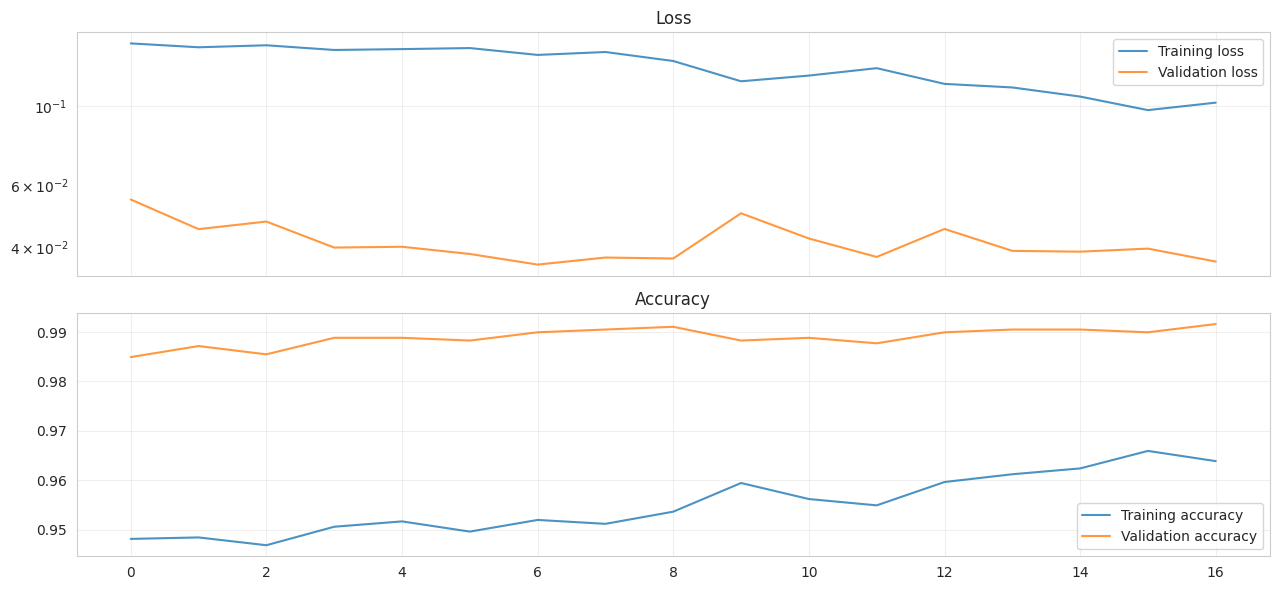

In [35]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.semilogy(history['loss'], label='Training loss', alpha=0.8)
ax1.semilogy(history['val_loss'], label='Validation loss', alpha=0.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=0.8)
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=0.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

# Evaluation

In [ ]:
def compute_metrics(labels, preds):
  """
  Computes classification metrics, arranged in a dict.
  """
  accuracy = round(accuracy_score(labels, preds), 4)
  precision = round(precision_score(labels, preds, average='weighted'), 4)
  recall = round(recall_score(labels, preds, average='weighted'), 4)
  f1 = round(f1_score(labels, preds, average='weighted'), 4)

  result_dict = {
      "acc":  accuracy,
      "prec": precision,
      "rec":  recall,
      "f1":  f1,
  }

  return result_dict

In [ ]:
# preds_train     = np.argmax(MODEL.predict(X_train, verbose=0), axis=-1)
# labels_train    = y_train
preds_val       = np.argmax(MODEL.predict(X_val, verbose=0), axis=-1) # compute validation predictions
labels_val      = y_val # validation labels

In [38]:
# print(f"TRAIN METRICS: \n {compute_metrics(labels_train, preds_train)}")
print(f"VAL METRICS: \n {compute_metrics(labels_val, preds_val)}")

VAL METRICS: 
 {'acc': 0.99, 'prec': 0.9901, 'rec': 0.99, 'f1': 0.99}


In [ ]:
# cmn_train = confusion_matrix(labels_train, preds_train, normalize="true")
cmn_val = confusion_matrix(labels_val, preds_val, normalize="true") # normalized validation confusion matrix

# cm_train = confusion_matrix(labels_train, preds_train)
cm_val = confusion_matrix(labels_val, preds_val) # absolute validation confusion matrix

In [ ]:
def make_cm_fig(cm, cmn, title=None):
  """
  Returns figure arranging normalised and absolute confusion matrix side-by-side
  """
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  fig.suptitle(title, fontsize=16)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True, ax=axs[0])
  axs[0].set_title("Conf. matrix")
  axs[0].set_xlabel("Predicted label")
  axs[0].set_ylabel("True label")

  sns.heatmap(cmn, annot=True, fmt=".2%", cmap="Blues", linewidths=.5, square=True, ax=axs[1])
  axs[1].set_title("Norm. conf. matrix")
  axs[1].set_xlabel("Predicted label")
  axs[1].set_ylabel("True label")

  return fig

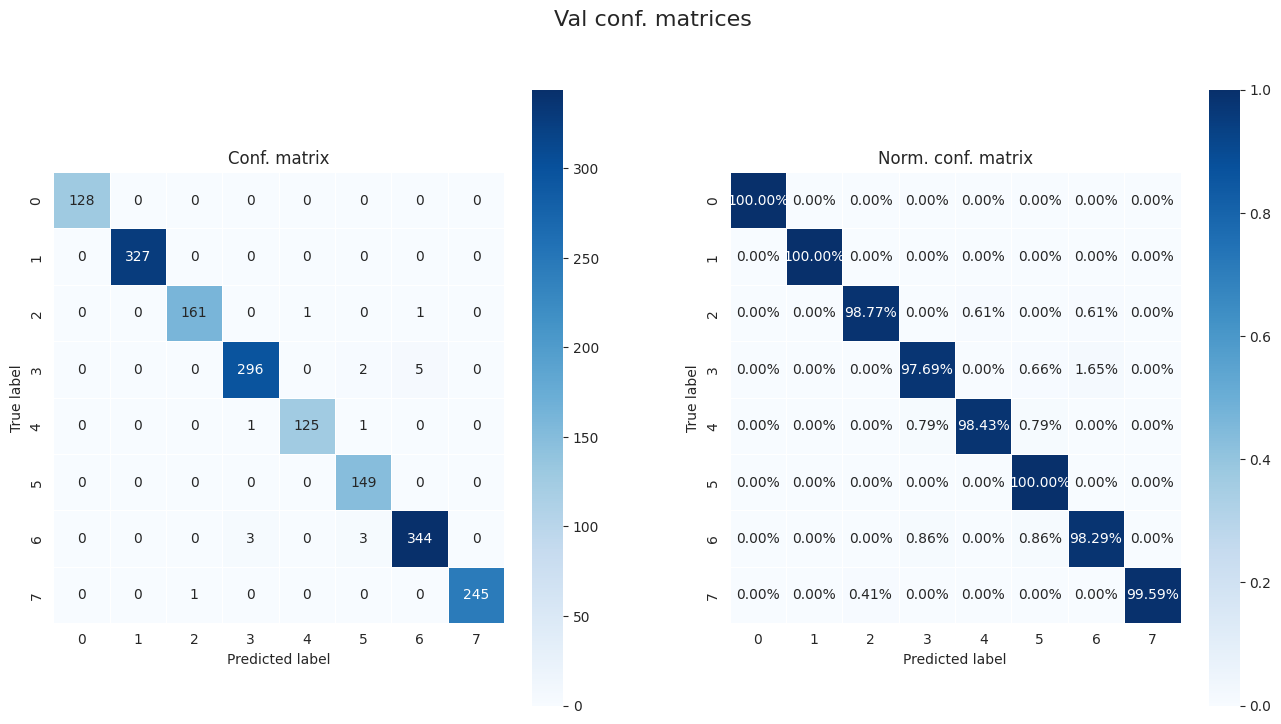

In [41]:
# make_cm_fig(cm_train, cmn_train, title="Train conf. matrices").show()
make_cm_fig(cm_val, cmn_val, title="Val conf. matrices").show()

# Model Exporting

**No TTA**

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras

class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('params.keras', compile=False)
        self.neural_network.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=None, metrics=["accuracy"])

    def predict(self, X):
        X = tf.convert_to_tensor(X/255.0, dtype=tf.float32)
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

**TTA**

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('params.keras', compile=False)
        self.neural_network.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=None, metrics=["accuracy"])
        self.tta_augmentation = tfk.Sequential([
          tfkl.RandomZoom(height_factor=0.1, fill_mode="reflect"),
          tfkl.RandomFlip("horizontal_and_vertical"),
          tfkl.RandomRotation(1),
          tfkl.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect"),
        ])
        self.tta_steps = 10
        self.batch_size = 32

    def predict(self, X):
        X = tf.convert_to_tensor(X/255.0, dtype=tf.float32)
        num_samples = X.shape[0]

        all_predictions = []
        for batch_start in range(0, num_samples, self.batch_size):
            batch_end = min(batch_start + self.batch_size, num_samples)
            batch_X = X[batch_start:batch_end]

            batch_predictions = []
            augmented_batch_X = self.tta_augmentation(batch_X, training=True)  # Augment the batch
            for _ in range(self.tta_steps):
                preds = self.neural_network.predict(augmented_batch_X)  # Predict on augmented batch
                preds = np.argmax(preds, axis=1)
                batch_predictions.append(preds)

            batch_predictions = np.array(batch_predictions).T
            batch_final_predictions = [np.argmax(np.bincount(sample_preds)) for sample_preds in batch_predictions]
            all_predictions.extend(batch_final_predictions)

        return np.array(all_predictions)

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py params.keras